In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import metpy.calc as mpcalc
import metpy.units as units

In [16]:
def get_era5_thetae_grad(t):

    step=1
    LONG = np.array([145,165])
    LAT = np.array([-45,-25])
    lon_slice = slice(LONG.min(),LONG.max(),step)
    lat_slice = slice(LAT.max(),LAT.min(),step)

    temp = xr.open_dataset("/g/data/rt52/era5/pressure-levels/reanalysis/t/2023/t_era5_oper_pl_20231001-20231031.nc").t.sel(level=850,time=t,longitude=lon_slice,latitude=lat_slice)
    q = xr.open_dataset("/g/data/rt52/era5/pressure-levels/reanalysis/q/2023/q_era5_oper_pl_20231001-20231031.nc").q.sel(level=850,time=t,longitude=lon_slice,latitude=lat_slice)    
    msl = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/msl/2023/msl_era5_oper_sfc_20231001-20231031.nc").msl\
            .sel(time=t,longitude=slice(120,170),latitude=slice(-10,-60)).rolling({"latitude":6,"longitude":6}).mean().sel(longitude=lon_slice,latitude=lat_slice)

    ta_unit = units.units.K*temp
    dp_unit = mpcalc.dewpoint_from_specific_humidity(850 * units.units.hectopascals, ta_unit, q*units.units.dimensionless)
    thetae = np.array(mpcalc.equivalent_potential_temperature(850 * units.units.hectopascals, ta_unit, dp_unit))
    theta = np.array(mpcalc.potential_temperature(850 * units.units.hectopascals, ta_unit))    
    
    era5_lon = temp.longitude.values
    era5_lat = temp.latitude.values
    x, y = np.meshgrid(era5_lon,era5_lat)
    dx, dy = mpcalc.lat_lon_grid_deltas(x,y)

    ddy_thetae = mpcalc.first_derivative( thetae, delta=dy, axis=0)
    ddx_thetae = mpcalc.first_derivative( thetae, delta=dx, axis=1)
    mag_thetae = np.sqrt( ddx_thetae**2 + ddy_thetae**2)
    
    ddy_theta = mpcalc.first_derivative( theta, delta=dy, axis=0)
    ddx_theta = mpcalc.first_derivative( theta, delta=dx, axis=1)
    mag_theta = np.sqrt( ddx_theta**2 + ddy_theta**2)    
    
    return theta, thetae, mag_thetae, mag_theta, era5_lon, era5_lat, msl

def load_era5(t):
    #Load ERA5
    era5_u = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/10u/2023/10u_era5_oper_sfc_20231001-20231031.nc")
    era5_v = xr.open_dataset("/g/data/rt52/era5/single-levels/reanalysis/10v/2023/10v_era5_oper_sfc_20231001-20231031.nc")

    step=4
    LONG = np.array([145,165])
    LAT = np.array([-45,-25])
    lon_slice = slice(LONG.min(),LONG.max())
    lat_slice = slice(LAT.max(),LAT.min())
    era5_u_slice = era5_u.sel(time=t.split("_")[0] + " " + t.split("_")[1],longitude=lon_slice,latitude=lat_slice).\
                        coarsen({"longitude":step,"latitude":step},boundary="trim").mean()
    era5_v_slice = era5_v.sel(time=t.split("_")[0] + " " + t.split("_")[1],longitude=lon_slice,latitude=lat_slice).\
                        coarsen({"longitude":step,"latitude":step},boundary="trim").mean()    

    theta, thetae, mag_thetae, mag_theta, era5_lon, era5_lat, msl = get_era5_thetae_grad(t.split("_")[0] + " " + t.split("_")[1])
    
    return era5_u_slice, era5_v_slice, theta, thetae, mag_thetae, mag_theta, era5_lon, era5_lat, msl

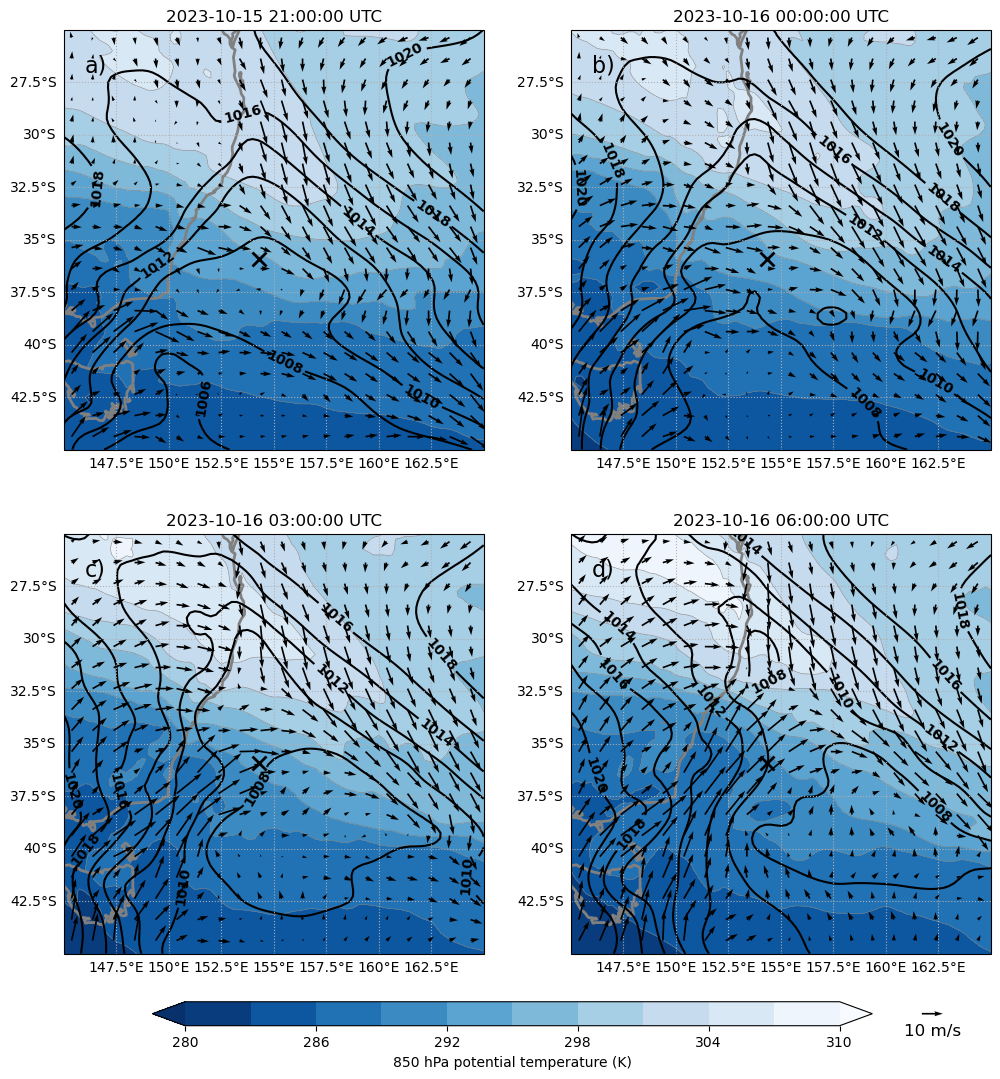

In [20]:
plt.figure(figsize=[12,12])

cnt=1
for t,letter in zip(["2023-10-15_21:00:00", "2023-10-16_00:00:00", "2023-10-16_03:00:00", "2023-10-16_06:00:00"],["a","b","c","d"]):

    #Plot ERA5
    ax=plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())
    era5_u_slice, era5_v_slice, theta, thetae, mag_thetae, mag_theta, era5_lon, era5_lat, msl = load_era5(t)
    cf=ax.contourf(era5_lon,era5_lat,theta,cmap="Blues_r",extend="both",alpha=1,levels=np.linspace(280,310,11))
    ax.contour(era5_lon,era5_lat,theta,colors="grey",extend="both",alpha=0.8,levels=np.linspace(280,310,11),linewidths=0.5)    
    c=ax.contour(era5_lon,era5_lat,(msl/100).values,colors=["k"],levels=np.arange(1006,1022,2))
    text = plt.clabel(c,colors='k')
    [t.set_fontweight("bold") for t in text]
    x,y = np.meshgrid(era5_u_slice.longitude.values,era5_u_slice.latitude.values)
    q = ax.quiver(x,y,era5_u_slice.u10,era5_v_slice.v10,width=0.004,color="k",zorder=10,scale=200)
    ax.coastlines(color="grey",lw=2)
    ax.gridlines(ls=":",draw_labels=["left","bottom"])
    ax.plot(154.3239, -35.9070, marker="x", color="k", ms=10, mew=2)
    plt.title(t.replace("_"," ")+" UTC")
    # plt.contourf(era5_lon, era5_lat, np.array(mag_thetae.to("1/km")*100) > 5, colors=["none","tab:blue"])
    ax.text(0.05,0.9,letter+")",size=16,transform=ax.transAxes)    
    cnt=cnt+1
    
plt.quiverkey(q,0.85,0.06,10,"10 m/s",labelpos="S",coordinates="figure",fontproperties={"size":12})
    
cb=plt.colorbar(cf,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("850 hPa potential temperature (K)")
plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/synoptic.jpeg",dpi=500,bbox_inches="tight")